In [1]:
import pandas as pd
import numpy as np
from process_data import pre_process_data
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
np.random.seed(10) # Set a seed to make our results reproducible

### Undertanding the data

In [2]:
from process_data import pre_process_data
X_train = pd.read_csv('german_credit_train.csv', sep=",")
y_train = X_train['Creditability']
X_train = pre_process_data(X_train)
X_train = X_train.drop(columns=['Age (years)'])
X_train['Creditability'] = ['Good' if x == 1 else 'Bad' for x in y_train] 

print(X_train.shape)
X_train.head()

(600, 11)


,Account Balance,Payment Status,Savings/Stock Value,Employment Length,Sex & Marital Status,NumberCredits,Guarantors,Concurrent Credits,Purpose,AgeGroups,Creditability
0,SomeBalance,NoProblem,NoSavings,OneToFour,MaleSingle,OnePlus,No,NoCredit,UsedCar,MidAgeAdult,Good
1,SomeBalance,PaidUp,NoSavings,AboveSevent,MaleMarried,One,No,NoCredit,HouseRelated,MidAgeAdult,Good
2,NoBalance,NoProblem,NoSavings,BellowOneYear,MaleMarried,OnePlus,No,NoCredit,NewCar,MidAgeAdult,Good
3,NoBalance,NoProblem,BellowHundred,FourToSevent,MaleMarried,One,No,NoCredit,Other,MidAgeAdult,Good
4,SomeBalance,PaidUp,NoSavings,OneToFour,MaleMarried,One,No,NoCredit,HouseRelated,Young,Good


#### Distribution of Sex & Marital Status
We can visualise each column individually, since all columns but the Age (years) column are categorical, we use a bar plot to visualise the distribution of each variable.

This graphic shows the distribution of Sex & Marital Status. It can be seen that this data set is predominantly about married men and underrepresent women. 

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

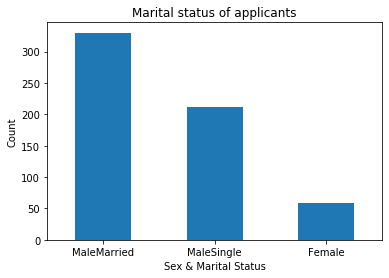

In [3]:
# Visualizing a few variables, sex and marital status
X_train['Sex & Marital Status'].value_counts().plot(kind='bar', title="Marital status of applicants", )
plt.ylabel('Count')
plt.xlabel('Sex & Marital Status')
plt.xticks(rotation=0)

#### Distribution of Creditability
Let us look at the distribution of the response variable. That is the distribution of creditability.
We can see that the data contains a lot more good credits that bad credits. 

This is a case of imbalance data set, meaning that we have an inequal distribution of classes in the training data set

(array([0, 1]), <a list of 2 Text xticklabel objects>)

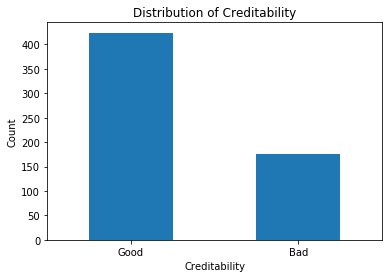

In [4]:
X_train['Creditability'].value_counts().plot(kind='bar', title="Distribution of Creditability", )
plt.ylabel('Count')
plt.xlabel('Creditability')
plt.xticks(rotation=0)

#### Credibability by age groups

We can also look at the relationship between some of the variables and the response variable creditability.

The process_data.py file provides a function plot_marginal_distribution that allows you to visualize the distribution of a variable within fixed categories of another variable. 
This is known as marginal distribution

For example, this graphic shows the marginal distribution of age groups within fixed categories of Credibility. Or in simple terms, the distribution of age groups per credit risk.


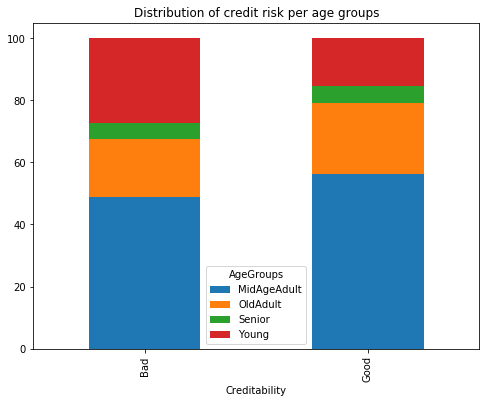

In [5]:
from process_data import plot_marginal_distribution
plot_marginal_distribution(X_train, var1='AgeGroups', var2='Creditability', 
                           title='Distribution of credit risk per age groups')

## Building the model

### Prepare test data

In [6]:
X_train = pd.read_csv('german_credit_train.csv', sep=",")
X_test = pd.read_csv('german_credit_test.csv', sep=",")

y_train = X_train['Creditability']
y_test = X_test['Creditability']


# Preprocess the data set
X_train = pre_process_data(X_train)
#Drop the 'Age (years) column'
X_train = X_train.drop(columns=['Age (years)'])

# Create dummy variables using the DictVectorizer class 
dv = DictVectorizer(sparse=False)
dv = dv.fit(X_train.to_dict('records'))

dummy_train = dv.transform(X_train.to_dict('records'))
cols = dv.get_feature_names()

# Convert the data back to data frame
dummy_train = pd.DataFrame(dummy_train, index=X_train.index, columns=cols)
new_cols = {}
for key in cols:
    new_cols[key] = key.replace('=', '_')

dummy_train = dummy_train.rename(columns=new_cols)

In [7]:
dummy_train.head()

,Account Balance_NoAccount,Account Balance_NoBalance,Account Balance_SomeBalance,AgeGroups_MidAgeAdult,AgeGroups_OldAdult,AgeGroups_Senior,AgeGroups_Young,Concurrent Credits_NoCredit,Concurrent Credits_OtherBanks,Employment Length_AboveSevent,...,Purpose_NewCar,Purpose_Other,Purpose_UsedCar,Savings/Stock Value_AboveThousand,Savings/Stock Value_BellowHundred,Savings/Stock Value_NoSavings,Savings/Stock Value_Other,Sex & Marital Status_Female,Sex & Marital Status_MaleMarried,Sex & Marital Status_MaleSingle
0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [8]:
input_data = {"Account Balance": 2,
"Payment Status of Previous Credit": 2,
"Value Savings/Stocks": 1, 
"Length of current employment": 3, 
"Sex & Marital Status": 3,
"No of Credits at this Bank": 1, 
"Guarantors": 2, 
"Concurrent Credits": 3,
"Purpose": 4, 
"Age (years)": 42}

# Save the dict_vectorizer for later use
import pickle
with open('./webservice/static/dict_vectorizer.pkl', 'wb') as stream:
    pickle.dump(dv, stream)

### Train a classifier

In [9]:
# Training the model
from sklearn.linear_model import LogisticRegression

data_scaler = StandardScaler()
dummy_train = data_scaler.fit_transform(dummy_train)

classifier = LogisticRegression(random_state=12, class_weight='balanced')
# Train the model
classifier = classifier.fit(dummy_train, y_train)

# Save the scaler 
with open('./webservice/static/data_scaler.pkl', 'wb') as stream:
    pickle.dump(data_scaler, stream)

### Preparing test data

In [10]:
# Preparing test data
X_test = pre_process_data(X_test)
X_test = X_test.drop(columns=['Age (years)'])

dummy_test = dv.transform(X_test.to_dict('records'))
cols = dv.get_feature_names()

# Convert the data back to data frame
dummy_test = pd.DataFrame(dummy_test, index=X_test.index, columns=cols)
new_cols = {}
for key in cols:
    new_cols[key] = key.replace('=', '_')

dummy_test = dummy_test.rename(columns=new_cols)

[[191  85]
 [ 36  88]]
#### Model's accuracy:  0.70


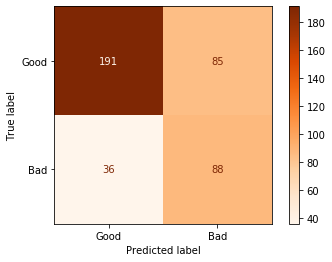

In [11]:
y_preds = classifier.predict(data_scaler.transform(dummy_test))
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
conf_matrix = confusion_matrix(y_test, y_preds, labels=[1, 0])

print(conf_matrix)

print("#### Model's accuracy:  {:.2f}".format(classifier.score(data_scaler.transform(dummy_test), y_test)))

class_names = ['Good', 'Bad']
disp = plot_confusion_matrix(classifier, data_scaler.transform(dummy_test), 
                             y_test, display_labels=class_names, 
                             cmap=plt.cm.Oranges, 
                             normalize=None, values_format='.0f', labels=[1, 0])

In [12]:
# Saving the model to disk, for later use
import pickle

with open('./webservice/static/credit_model.pkl', 'wb') as stream:
    pickle.dump(classifier, stream)

## Pipeline

In [13]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler, FunctionTransformer

from sklearn.pipeline import Pipeline

class PreProcessData(TransformerMixin):

    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):    
        return pre_process_data(X)
    

PreProcessData = FunctionTransformer(pre_process_data)
    
    
class DummyTransformer(TransformerMixin):
    
    def __init__(self):
        pass

    def fit(self, X, y=None):
        Xdict = X.to_dict('records')
        self.dv = DictVectorizer(sparse=False)
        self.dv.fit(Xdict)
        return self

    def transform(self, X):
        Xdict = X.to_dict('records')
        Xt = self.dv.transform(Xdict)
        cols = self.dv.get_feature_names()
        Xdum = pd.DataFrame(Xt, index=X.index, columns=cols)
        new_cols = {}
        for key in cols:
            new_cols[key] = key.replace('=', '_')
        return Xdum.rename(columns=new_cols)
    

class DFStandardScaler(TransformerMixin):
    
    def __init__(self):
        self.ss = None

    def fit(self, X, y=None):
        self.ss = StandardScaler().fit(X)
        return self

    def transform(self, X):
        Xss = self.ss.transform(X)
        Xscaled = pd.DataFrame(Xss, index=X.index, 
                               columns=X.columns)
        return Xscaled
    
class DropColumns(TransformerMixin):

    def __init__(self, cols):
        self.cols = cols

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        Xcols = X.drop(columns=self.cols) 
        return Xcols

In [14]:
# Building the pipeline

X_train = pd.read_csv('german_credit_train.csv', sep=",")
X_test = pd.read_csv('german_credit_test.csv', sep=",")

y_train = X_train['Creditability']

COLUMNS_TO_DROP = ['Age (years)']


model_pipeline = Pipeline(steps=[('pre_process_data', PreProcessData), 
                                 ('drop_columns', DropColumns(COLUMNS_TO_DROP)), 
                                 ('dummies',DummyTransformer()), 
                                 ('scale', DFStandardScaler()),
                                 ('logistic_regression', LogisticRegression(random_state=12, class_weight='balanced'))
                                 ])

model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('pre_process_data',
                 FunctionTransformer(func=<function pre_process_data at 0x0000024A12E02488>)),
                ('drop_columns',
                 <__main__.DropColumns object at 0x0000024A14549710>),
                ('dummies',
                 <__main__.DummyTransformer object at 0x0000024A14549B70>),
                ('scale',
                 <__main__.DFStandardScaler object at 0x0000024A1302D128>),
                ('logistic_regression',
                 LogisticRegression(class_weight='balanced', random_state=12))])

In [15]:
predictions  = model_pipeline.predict(X_test)
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
conf_matrix = confusion_matrix(X_test['Creditability'], predictions, labels=[1, 0])


conf_matrix

array([[191,  85],
       [ 36,  88]], dtype=int64)

In [16]:
import logging
logging.critical('checking logging')
logging.warning('Logging does work')

CRITICAL:root:checking logging


## Tutorial on AI fairness

In [17]:
X_train = pd.read_csv('german_credit_train.csv', sep=",")
X_test = pd.read_csv('german_credit_test.csv', sep=",")

y_train = X_train['Creditability']
y_test = X_test['Creditability']


# Preprocess the data set
X_train = pre_process_data(X_train)
#Drop the 'Age (years) column'
X_train = X_train.drop(columns=['Age (years)'])
X_train['Creditability'] = ['Good' if x == 1 else 'Bad' for x in y_train] 

In [18]:
X_train.head()

,Account Balance,Payment Status,Savings/Stock Value,Employment Length,Sex & Marital Status,NumberCredits,Guarantors,Concurrent Credits,Purpose,AgeGroups,Creditability
0,SomeBalance,NoProblem,NoSavings,OneToFour,MaleSingle,OnePlus,No,NoCredit,UsedCar,MidAgeAdult,Good
1,SomeBalance,PaidUp,NoSavings,AboveSevent,MaleMarried,One,No,NoCredit,HouseRelated,MidAgeAdult,Good
2,NoBalance,NoProblem,NoSavings,BellowOneYear,MaleMarried,OnePlus,No,NoCredit,NewCar,MidAgeAdult,Good
3,NoBalance,NoProblem,BellowHundred,FourToSevent,MaleMarried,One,No,NoCredit,Other,MidAgeAdult,Good
4,SomeBalance,PaidUp,NoSavings,OneToFour,MaleMarried,One,No,NoCredit,HouseRelated,Young,Good


C:\Users\Ghislain Landry\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


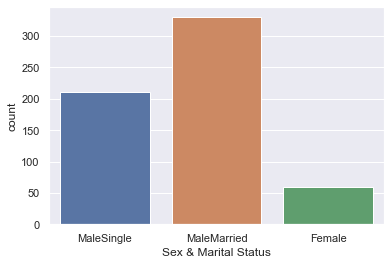

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
ax = sns.countplot(x="Sex & Marital Status", data=X_train)

Text(0.5, 0, 'Age groups')

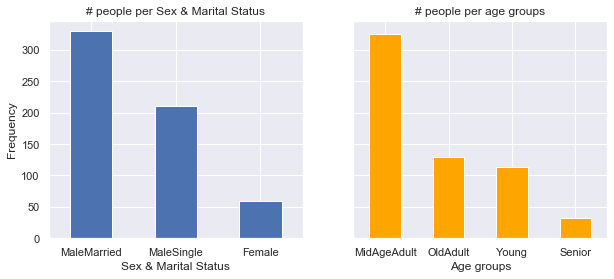

In [20]:
fig, ax = plt.subplots(nrows = 1, ncols=2, sharex=False, sharey=True, figsize=(10,4))
X_train['Sex & Marital Status'].value_counts().plot(kind='bar', title='# people per Sex & Marital Status', rot=0, ax=ax[0])
X_train['AgeGroups'].value_counts().plot(kind='bar', title='# people per age groups', color='orange', rot=0, ax=ax[1])
ax[0].set_ylabel("Frequency")
ax[0].set_xlabel("Sex & Marital Status")
ax[1].set_xlabel("Age groups")

In [21]:
ct = pd.crosstab(X_train['Creditability'], 
                 X_train['AgeGroups'], 
                 rownames=['Creditability'], 
                 colnames=['Age Groups'], margins=True, margins_name='Total')
ct

Age Groups,MidAgeAdult,OldAdult,Senior,Young,Total
Creditability,,,,,
Bad,86,33,9,48,176
Good,239,97,23,65,424
Total,325,130,32,113,600


In [22]:
ct = pd.crosstab(X_train['Creditability'], 
                 X_train['AgeGroups'], 
                 rownames=['Creditability'], 
                 colnames=['Age Groups'], 
                 normalize='columns')
ct

Age Groups,MidAgeAdult,OldAdult,Senior,Young
Creditability,,,,
Bad,0.264615,0.253846,0.28125,0.424779
Good,0.735385,0.746154,0.71875,0.575221


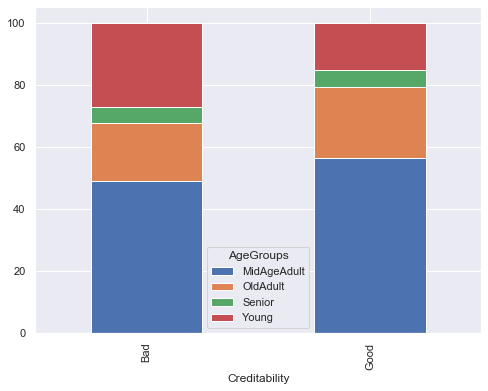

In [23]:
from process_data import plot_marginal_distribution
plot_marginal_distribution(X_train, var1='AgeGroups', var2='Creditability')

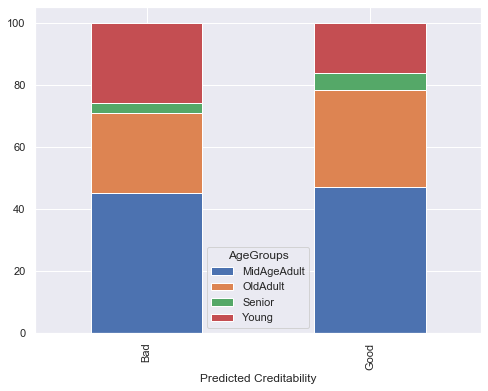

In [24]:
X_test_process = pre_process_data(X_test)
X_test_process['Predicted Creditability'] = ['Good' if x == 1 else 'Bad' for x in y_test]
plot_marginal_distribution(X_test_process, 
                           var1='AgeGroups', 
                           var2='Predicted Creditability')

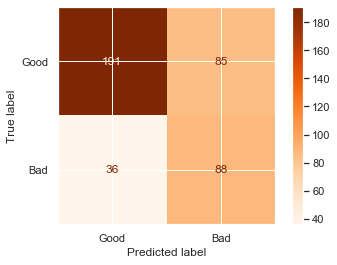

In [25]:
class_names = ['Good', 'Bad']
disp = plot_confusion_matrix(classifier, data_scaler.transform(dummy_test), 
                             y_test, display_labels=class_names, 
                             cmap=plt.cm.Oranges, 
                             normalize=None, values_format='.0f', labels=[1, 0])

## Confusion matrix for predictions within subgroups of the sensitive variable AgeGroups

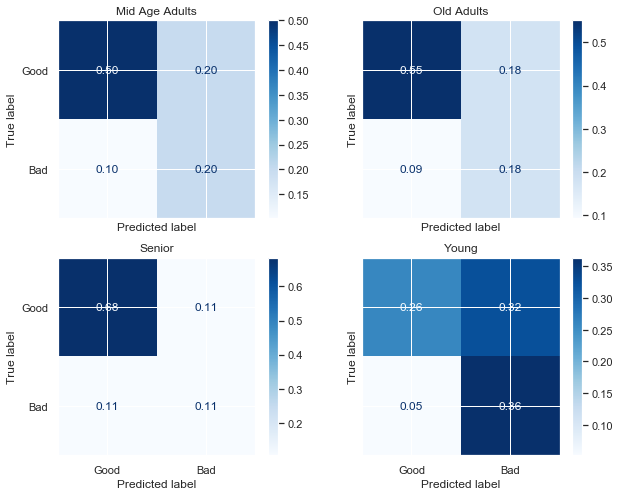

In [26]:
fig, ax = plt.subplots(nrows = 2, ncols=2, sharex=True, sharey=True, figsize=(10,8))

mapping = {'AgeGroups_MidAgeAdult': 'Mid Age Adults', 
           'AgeGroups_OldAdult': 'Old Adults', 
           'AgeGroups_Senior': 'Senior', 
           'AgeGroups_Young': 'Young'}

for age_group, axis in zip(['AgeGroups_MidAgeAdult', 'AgeGroups_OldAdult', 'AgeGroups_Senior', 'AgeGroups_Young'], 
                 [ax[0][0], ax[0][1], ax[1][0], ax[1][1]]):

    tmp_data = dummy_test[dummy_test[age_group] == 1]
    disp = plot_confusion_matrix(classifier, data_scaler.transform(tmp_data), 
                             y_test[tmp_data.index], display_labels=class_names, 
                             cmap=plt.cm.Blues, 
                             normalize='all', values_format='.2f', labels=[1, 0], ax=axis)
    axis.set_title(mapping[age_group])

Since the data seems to be biased only against young people, we will combine all other Age group categories for the rest of our analysis 

## Training on the new data set
Data set with only two groups for the AgeGroups sensitive attribute

Redefine the AgeGroups feature as follows: 

* ‘Old’ if age group is either 'Adult', 'OldAdult’ or 'Senior’
* Young otherwise

We use the pipeline that we just built, however, we have added a new transformer to convert the AgeGroups feature accordingly


### Creating the new data set

In [27]:
X_train = pd.read_csv('german_credit_train.csv', sep=",")
X_test = pd.read_csv('german_credit_test.csv', sep=",")
y_train = X_train['Creditability']
y_test = X_test['Creditability']

def new_age_groups(data):
    """ convert age groups to old and young"""
    data['AgeGroups'] = ['Young' if x == 'Young' else 'Old' for x in data['AgeGroups']]
    return data

Xtrain = new_age_groups(pre_process_data(X_train))
Xtest = new_age_groups(pre_process_data(X_test))

### Verify that the new data set is biased against Young people

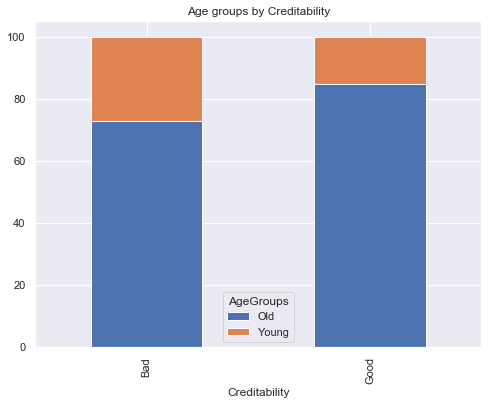

In [28]:
Xtrain['Creditability'] = ['Good' if x == 1 
                           else 'Bad' for x in y_train]
plot_marginal_distribution(Xtrain, var1='AgeGroups', 
                           var2='Creditability',
                           title="Age groups by Creditability")

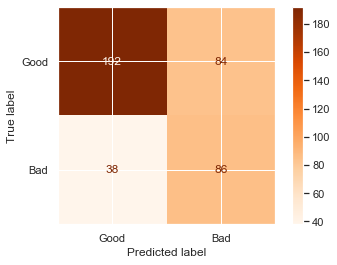

In [29]:
### Train a model on the new data

np.random.seed(10)

CreateNewAgeGroups = FunctionTransformer(new_age_groups)

model_pipeline = Pipeline(steps=[('pre_process_data', PreProcessData),
                                 ('create_new_age_groups', CreateNewAgeGroups),
                                 ('drop_columns', DropColumns(['Age (years)'])), 
                                 ('dummies',DummyTransformer()), 
                                 ('scale', DFStandardScaler()),
                                 ('logistic_regression', LogisticRegression(random_state=12, class_weight='balanced'))
                                 ])
# train the pipeline
model_pipeline.fit(X_train, y_train)

class_names = ['Good', 'Bad']
disp = plot_confusion_matrix(model_pipeline, X_test, 
                             y_test, display_labels=class_names, 
                             cmap=plt.cm.Oranges, 
                             normalize=None, values_format='.0f', labels=[1, 0])

## Verify that the yound age group is still unprivileged 

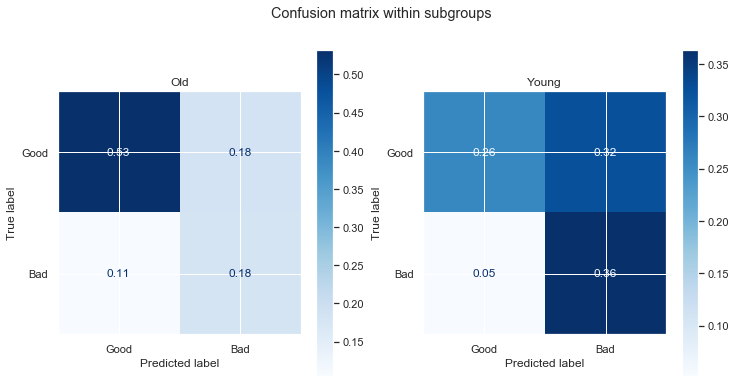

In [33]:
from process_data import plot_confusion_matrix_subgroups
import matplotlib.pyplot as plt

func = lambda x: 'Young' if x in range(0, 26) else 'Old'
plot_confusion_matrix_subgroups(model_pipeline, X_test, y_test, 
                                fig_nrows=1, fig_ncols=2, 
                                figsize=(12, 6), 
                                key_column = 'Age (years)',
                                class_names = ['Good', 'Bad'], 
                                groups = ['Old', 'Young'], 
                                group_function=func)

### Preparing data for AIF360

In [34]:
from aif360.datasets import Dataset, StandardDataset

from aif360.algorithms.preprocessing import LFR
from aif360.algorithms.preprocessing.reweighing import Reweighing


X_train = pd.read_csv('german_credit_train.csv', sep=",")
X_test = pd.read_csv('german_credit_test.csv', sep=",")

Xtrain = pre_process_data(X_train)
Xtest = pre_process_data(X_test)

Xtrain['AgeGroups'] = [0 if x == 'Young' else 1 
                       for x in Xtrain['AgeGroups']]
Xtest['AgeGroups'] = [0 if x == 'Young' else 1 
                       for x in Xtest['AgeGroups']]

# Remove age group
Xtrain = Xtrain.drop(columns=['Age (years)'])
Xtest = Xtest.drop(columns=['Age (years)'])

Xtrain['Creditability'] = [x for x in X_train['Creditability']]
Xtest['Creditability'] = [x for x in X_test['Creditability']]

aif360_train_data = StandardDataset(Xtrain.copy(), 
                       label_name='Creditability', 
                       favorable_classes=[1], 
                       protected_attribute_names=['AgeGroups'], 
                       privileged_classes=[lambda x: x == 1], 
                       categorical_features=['Account Balance', 'Payment Status', 
                                             'Savings/Stock Value', 'Employment Length', 
                                             'NumberCredits', 'Guarantors', 
                                             'Concurrent Credits', 'Purpose', 'Sex & Marital Status'])

### Computing fairness metric on the dtaa

In [35]:
from aif360.metrics import BinaryLabelDatasetMetric

privileged_groups = [{'AgeGroups': 1.0}]
unprivileged_groups = [{'AgeGroups': 0.0}]

metric_orig_train = BinaryLabelDatasetMetric(aif360_train_data, 
                                               unprivileged_groups=unprivileged_groups,
                                               privileged_groups=privileged_groups)

np.round(metric_orig_train.mean_difference(), 5)

-0.16195

### Reweighting data

In [36]:
np.random.seed(71)

from aif360.algorithms.preprocessing import Reweighing

RW = Reweighing(unprivileged_groups=unprivileged_groups, 
                privileged_groups=privileged_groups)
RW.fit(aif360_train_data)

dataset_transf_train = RW.transform(aif360_train_data)

### Fairness metric on the transformed data

In [37]:
metric_transf_train = BinaryLabelDatasetMetric(dataset_transf_train, 
                                               unprivileged_groups=unprivileged_groups,
                                               privileged_groups=privileged_groups)

np.round(metric_transf_train.mean_difference(), 5)

-0.0

## Building a classifier on transformed data 

In [38]:
scaler = StandardScaler()
x_train = dataset_transf_train.features
y_train = dataset_transf_train.labels.ravel()
#w_train = dataset_transf_train.instance_weights.ravel()
x_train = scaler.fit_transform(x_train)

clf2 = LogisticRegression(random_state=12, class_weight='balanced')
clf2 = clf2.fit(x_train, y_train, sample_weight=dataset_transf_train.instance_weights)

### Preparing test data

In [39]:
aif360_test_data = StandardDataset(Xtest.copy(), 
                       label_name='Creditability', 
                       favorable_classes=[1], 
                       protected_attribute_names=['AgeGroups'], 
                       privileged_classes=[lambda x: x == 1], 
                       categorical_features=['Account Balance', 'Payment Status', 
                                             'Savings/Stock Value', 'Employment Length', 
                                             'NumberCredits', 'Guarantors', 
                                             'Concurrent Credits', 'Purpose', 'Sex & Marital Status'])

# trandforming test data
dataset_transf_test = RW.transform(aif360_test_data)

### Predictions and confusion matrix on test data

Model accuracy 0.66 


'#### Confusion matrix'

[[ 83  41]
 [ 94 182]]


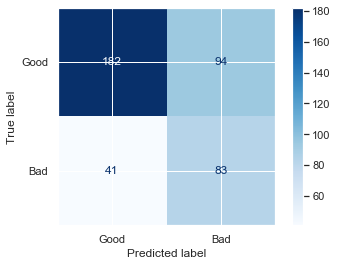

In [50]:
x_test = dataset_transf_test.features
y_test = dataset_transf_test.labels.ravel()
x_test = scaler.transform(x_test)

predictions = clf2.predict(x_test)

print('Model accuracy {:.2f} '.format(clf2.score(x_test, y_test)))

display("#### Confusion matrix")

conf_matrix = confusion_matrix(y_test, predictions)

print(conf_matrix)

class_names = ['Good', 'Bad']
disp = plot_confusion_matrix(clf2, x_test, 
                             y_test, display_labels=class_names, 
                             cmap=plt.cm.Blues, 
                             normalize=None, values_format='.0f', labels=[1, 0])

## Confusion matrices within subgroups 

Text(0.5, 0.98, 'Confusion matrices for predictions within subgroups reweighted  data')

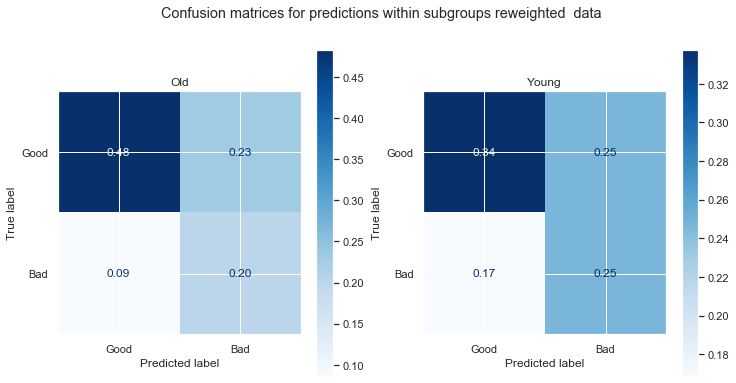

In [52]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharex=False)
    
age_groups = ['Young', 'Old']
class_names = ['Good', 'Bad']

mapping = {'1': 'Old', '0': 'Young'}

for age_group, axis in zip([1, 0], [ax1, ax2]):

    tmp_data = Xtest[Xtest['AgeGroups'] == age_group]
    disp = plot_confusion_matrix(clf2, x_test[tmp_data.index], 
                             y_test[tmp_data.index], display_labels=class_names, 
                             cmap=plt.cm.Blues, 
                             normalize='all', values_format='.2f', labels=[1, 0], ax=axis)
    axis.set_title(mapping[str(age_group)])

plt.suptitle('Confusion matrices for predictions within subgroups reweighted  data')

### Fairness metric on original data

-0.16195

### Fairness metric on transformed data

In [579]:

metric_transf_train = BinaryLabelDatasetMetric(dataset_transf_train, 
                                               unprivileged_groups=unprivileged_groups,
                                               privileged_groups=privileged_groups)

np.round(metric_transf_train.mean_difference(), 5)

-0.0

In [679]:
X_train = pd.read_csv('german_credit_train.csv', sep=",")
X_train.head()

,Creditability,Account Balance,Duration of Credit (month),Payment Status of Previous Credit,Purpose,Credit Amount,Value Savings/Stocks,Length of current employment,Instalment per cent,Sex & Marital Status,...,Duration in Current address,Most valuable available asset,Age (years),Concurrent Credits,Type of apartment,No of Credits at this Bank,Occupation,No of dependents,Telephone,Foreign Worker
0,1,4,18,4,2,1817,1,3,4,2,...,2,4,28,3,2,2,3,1,1,1
1,1,4,24,2,3,1278,1,5,4,3,...,1,1,36,3,2,1,4,1,2,1
2,1,2,12,4,1,1860,1,1,4,3,...,2,3,34,3,2,2,4,1,2,1
3,1,2,24,3,9,6967,2,4,4,3,...,4,3,36,3,1,1,4,1,2,1
4,1,3,36,2,3,3919,1,3,2,3,...,2,1,23,3,2,1,3,1,2,1


In [680]:
Counter(X_train['Payment Status of Previous Credit'])

Counter({4: 173, 2: 315, 3: 56, 1: 33, 0: 23})

In [681]:
Xtrain = pre_process_data(X_train)
Counter(Xtrain['Payment Status'])

Counter({'NoProblem': 567, 'SomeProblems': 33})

In [682]:
X_train.columns

Index(['Creditability', 'Account Balance', 'Duration of Credit (month)',
       'Payment Status of Previous Credit', 'Purpose', 'Credit Amount',
       'Value Savings/Stocks', 'Length of current employment',
       'Instalment per cent', 'Sex & Marital Status', 'Guarantors',
       'Duration in Current address', 'Most valuable available asset',
       'Age (years)', 'Concurrent Credits', 'Type of apartment',
       'No of Credits at this Bank', 'Occupation', 'No of dependents',
       'Telephone', 'Foreign Worker'],
      dtype='object')

In [691]:
Counter(X_train['No of Credits at this Bank'])

Counter({2: 209, 1: 373, 3: 16, 4: 2})

In [689]:
Counter(Xtrain['Concurrent Credits'])

Counter({'NoCredit': 484, 'OtherBanks': 116})

In [688]:
Xtrain.columns

Index(['Account Balance', 'Payment Status', 'Savings/Stock Value',
       'Employment Length', 'Sex & Marital Status', 'NumberCredits',
       'Guarantors', 'Concurrent Credits', 'Purpose', 'Age (years)',
       'AgeGroups'],
      dtype='object')

In [692]:
X_train['Age (years)'].describe()

count    600.000000
mean      35.111667
std       11.295804
min       20.000000
25%       27.000000
50%       32.000000
75%       41.000000
max       75.000000
Name: Age (years), dtype: float64

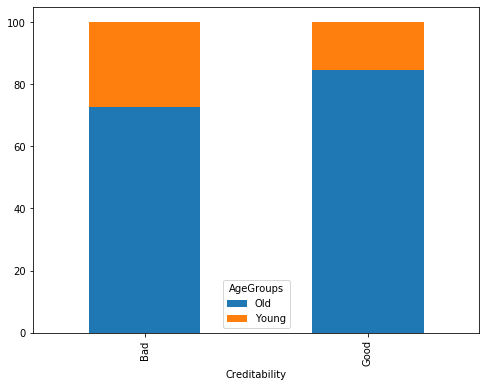

In [28]:
X_train = pd.read_csv('german_credit_train.csv', sep=",")
X_test = pd.read_csv('german_credit_test.csv', sep=",")
y_train = X_train['Creditability']
y_test = X_test['Creditability']

Xtrain = pre_process_data(X_train)
Xtest = pre_process_data(X_test)
Xtrain['AgeGroups'] = ['Young' if x == 'Young' else 'Old' for x in Xtrain['AgeGroups']]
Xtest['AgeGroups'] = ['Young' if x == 'Young' else 'Old' for x in Xtest['AgeGroups']]

# Remove age group
Xtrain = Xtrain.drop(columns=['Age (years)'])
Xtest = Xtest.drop(columns=['Age (years)'])
Xtrain['Creditability'] = ['Good' if x == 1 
                           else 'Bad' for x in y_train]
#from process_data import plot_marginal_distribution
plot_marginal_distribution(Xtrain, var1='AgeGroups', 
                           var2='Creditability')

In [31]:
(38512 - 37200) + 500

1812

In [32]:
4441.20+33 - 1500

2974.2

In [43]:
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

In [46]:
import sklearn
sklearn.__version__

'0.23.1'

In [48]:
import statsmodels
statsmodels.__version__

'0.10.0'

In [ ]:
temperature = pd.DataFrame({'day'})